In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('../Dataset'))
sys.path.append(os.path.abspath('..'))

import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from func_preprocesamiento import preprocesar

#### NO correr esto, vuelve a procesar datasets

In [2]:
dev_df = pd.read_csv('../Dataset/raw/dev.csv')
bins = pd.qcut(dev_df['precio_pesos_constantes'], q=5, labels=False)  # 4 cuartiles
train_dataset, val_dataset = train_test_split(dev_df, train_size=0.8, random_state=42, stratify=bins)

/tmp/ipykernel_9584/1655610193.py:1: DtypeWarning: Columns (8,33) have mixed types. Specify dtype option on import or set low_memory=False.
  dev_df = pd.read_csv('../Dataset/raw/dev.csv')


In [3]:
train_procesado = preprocesar(train_dataset, 'train')
direccion = '../Dataset/Procesado/train_procesado.csv'
train_procesado.to_csv(direccion, index=False)
train_procesado_categorico = pd.read_csv(direccion)

Columna a predecir: Laundry
Columna a predecir: Calefaccion
Columna a predecir: Jacuzzi
Columna a predecir: Gimnasio
Columna a predecir: Cisterna
Columna a predecir: AireAC
Columna a predecir: SalonFiestas
Columna a predecir: Amoblado
Columna a predecir: Antiguedad


In [3]:
df_val = preprocesar(val_dataset, 'val')
direccion = '../Dataset/Procesado/val_procesado.csv'
df_val.to_csv(direccion, index=False)
val_procesado_categorico = pd.read_csv(direccion)

Columna a predecir: Laundry
Columna a predecir: Calefaccion
Columna a predecir: Jacuzzi
Columna a predecir: Gimnasio
Columna a predecir: Cisterna
Columna a predecir: AireAC
Columna a predecir: SalonFiestas
Columna a predecir: Amoblado
Columna a predecir: Antiguedad
Columna a predecir: STotalM2
Columna a predecir: SConstrM2


## DATASET NUMERICO

In [4]:
#ARMAMOS EL DATASET NUMERICO SACANDO LAS COLUMNAS CATEGORICAS
direccion = '../Dataset/Procesado/train_procesado.csv'
train_procesado = pd.read_csv(direccion)

direccion = '../Dataset/Procesado/val_procesado.csv'
val_procesado = pd.read_csv(direccion)

### NUEVO

In [5]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns


direccion = '../Dataset/Procesado/train_procesado.csv'
train_procesado = pd.read_csv(direccion)
# Seleccionar las características a usar
X = train_procesado[['Cocheras', 'precio_pesos_constantes']]


# Configurar y entrenar el modelo Isolation Forest
iso_forest = IsolationForest(contamination=0.005, random_state=5)  # Ajusta contamination según tu criterio
iso_forest.fit(X)

# Predecir los outliers
train_procesado['anomaly_score'] = iso_forest.predict(X)

# Identificar outliers
outliers = train_procesado[train_procesado['anomaly_score'] == -1]


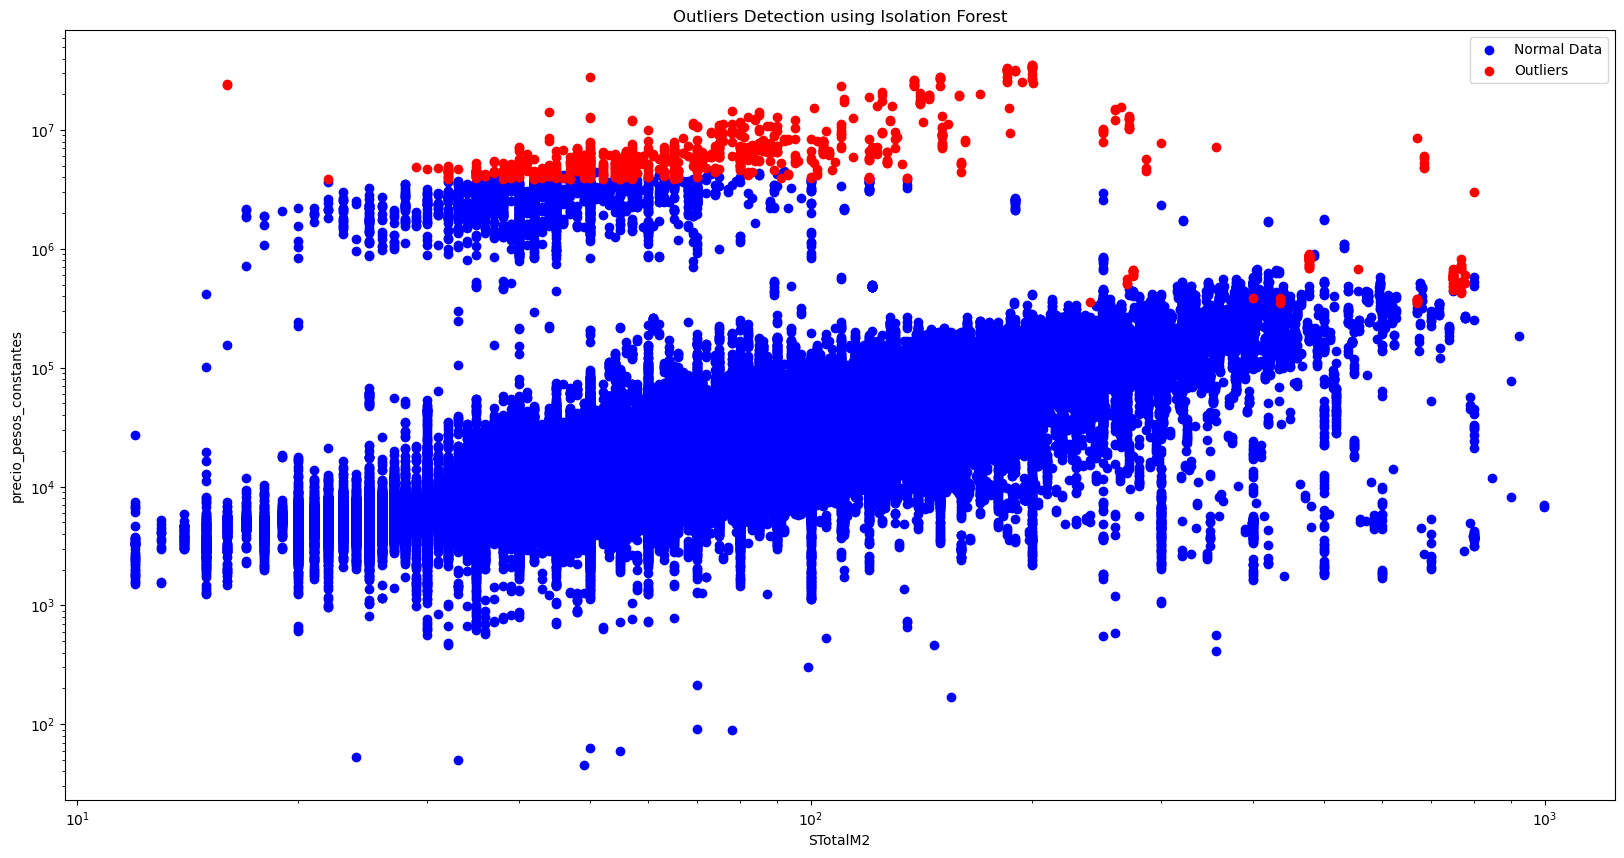

Cantidad de outliers: 897
Estos son los datos de los outliers:
        STotalM2  Antiguedad  Ambientes  precio_pesos_constantes
52          50.0           0          3             4.814576e+06
62          57.0           0          2             6.565331e+06
187        185.0           0          3             3.156169e+07
272         65.0           0          3             5.973854e+06
293        145.0           0          4             1.991285e+07
...          ...         ...        ...                      ...
182606      57.0           0          2             7.611132e+06
182647     750.0           2          5             5.809332e+05
182818      55.0           0          3             4.008713e+06
182901     127.0           0          3             5.384207e+06
183600      70.0           0          3             5.752600e+06

[897 rows x 4 columns]
        STotalM2  Antiguedad  Ambientes  precio_pesos_constantes
49243      200.0          30          4             3.518759e+07
180

In [6]:
plt.figure(figsize=(20, 10))

# Graficar los puntos normales
plt.scatter(train_procesado[train_procesado['anomaly_score'] == 1]['STotalM2'], 
            train_procesado[train_procesado['anomaly_score'] == 1]['precio_pesos_constantes'], 
            color='blue', label='Normal Data')

# Graficar los outliers
plt.scatter(outliers['STotalM2'], outliers['precio_pesos_constantes'], 
            color='red', label='Outliers')

# Agregar etiquetas y leyenda
plt.xlabel('STotalM2')
plt.ylabel('precio_pesos_constantes')
plt.title('Outliers Detection using Isolation Forest')
plt.legend()

# Establecer escala logarítmica
plt.xscale('log')
plt.yscale('log')

plt.show()

print('Cantidad de outliers:', outliers.shape[0])
print('Estos son los datos de los outliers:')
print(outliers[['STotalM2', 'Antiguedad', 'Ambientes', 'precio_pesos_constantes']])


top_10_max_price = train_procesado.nlargest(10, 'precio_pesos_constantes')

# Mostrar los metros cuadrados y el precio de estos registros
print(top_10_max_price[['STotalM2', 'Antiguedad', 'Ambientes', 'precio_pesos_constantes']])

Cantidad de clusters: [  -1    0    1 ... 1002 1003 1004]


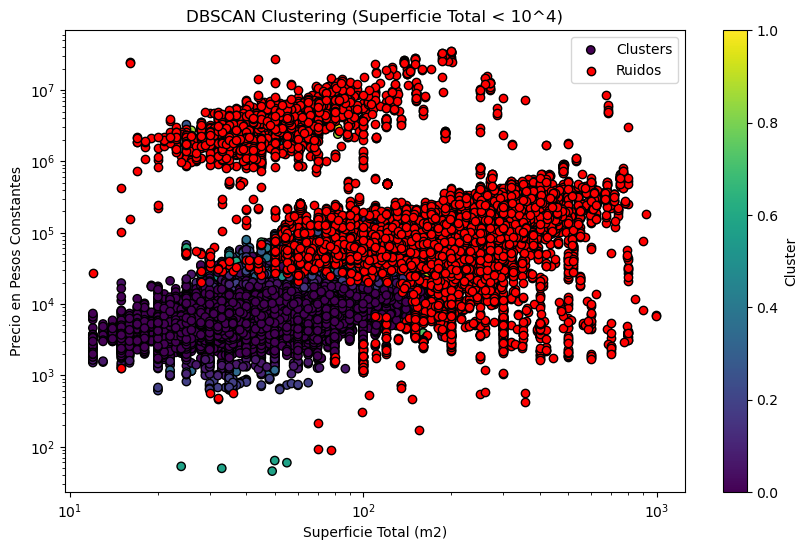

In [7]:
from sklearn.cluster import DBSCAN

# Parámetros óptimos
eps = 30  # Ajusta este valor según el gráfico de k-distancias
min_samples = 5
X = train_procesado[['STotalM2', 'precio_pesos_constantes']]

# Ejecutar DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(X)
print('Cantidad de clusters:', np.unique(labels))
# Agregar etiquetas de cluster a los datos
train_procesado['cluster'] = labels


# Graficar los datos filtrados
plt.figure(figsize=(10, 6))

# Graficar los puntos normales
plt.scatter(train_procesado[train_procesado['cluster'] != -1]['STotalM2'], 
            train_procesado[train_procesado['cluster'] != -1]['precio_pesos_constantes'], 
            c=train_procesado[train_procesado['cluster'] != -1]['cluster'], cmap='viridis', marker='o', edgecolor='k', label='Clusters')

# Graficar los ruidos
plt.scatter(train_procesado[train_procesado['cluster'] == -1]['STotalM2'], 
            train_procesado[train_procesado['cluster'] == -1]['precio_pesos_constantes'], 
            color='red', marker='o', edgecolor='k', label='Ruidos')

plt.xlabel('Superficie Total (m2)')
plt.ylabel('Precio en Pesos Constantes')
plt.title('DBSCAN Clustering (Superficie Total < 10^4)')
plt.colorbar(label='Cluster')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


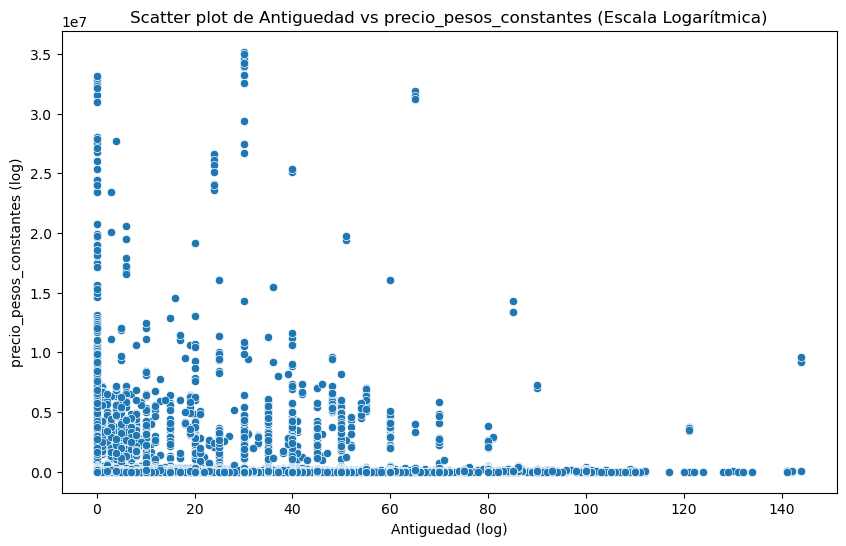

In [8]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x=train_procesado['Antiguedad'], y=train_procesado['precio_pesos_constantes'])
plt.title('Scatter plot de Antiguedad vs precio_pesos_constantes (Escala Logarítmica)')
plt.xlabel('Antiguedad (log)')
plt.ylabel('precio_pesos_constantes (log)')
plt.show()

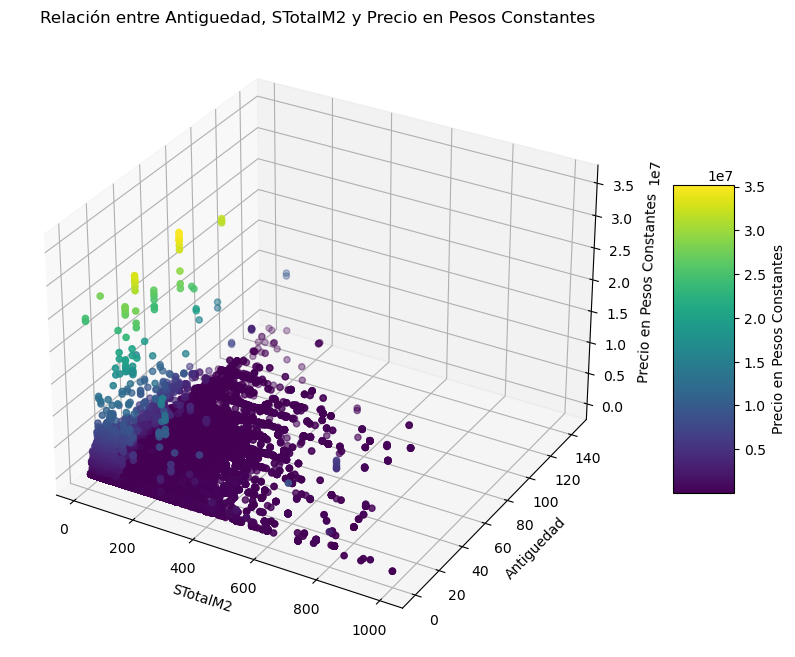

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Crear un scaler
scaler = MinMaxScaler()

# Normalizar la columna 'precio_pesos_constantes'
train_procesado['precio_pesos_constantes_normalizado'] = scaler.fit_transform(train_procesado[['precio_pesos_constantes']])

# Crear la figura y los ejes 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar los datos con colores según el precio en pesos constantes
sc = ax.scatter(train_procesado['STotalM2'],
                train_procesado['Antiguedad'],  
                train_procesado['precio_pesos_constantes'], 
                c=train_procesado['precio_pesos_constantes'], 
                cmap='viridis', 
                marker='o')

# Etiquetas de los ejes
ax.set_ylabel('Antiguedad')
ax.set_xlabel('STotalM2')
ax.set_zlabel('Precio en Pesos Constantes')

# Título del gráfico
ax.set_title('Relación entre Antiguedad, STotalM2 y Precio en Pesos Constantes')

# Añadir barra de color
cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Precio en Pesos Constantes')

# Mostrar el gráfico
plt.show()

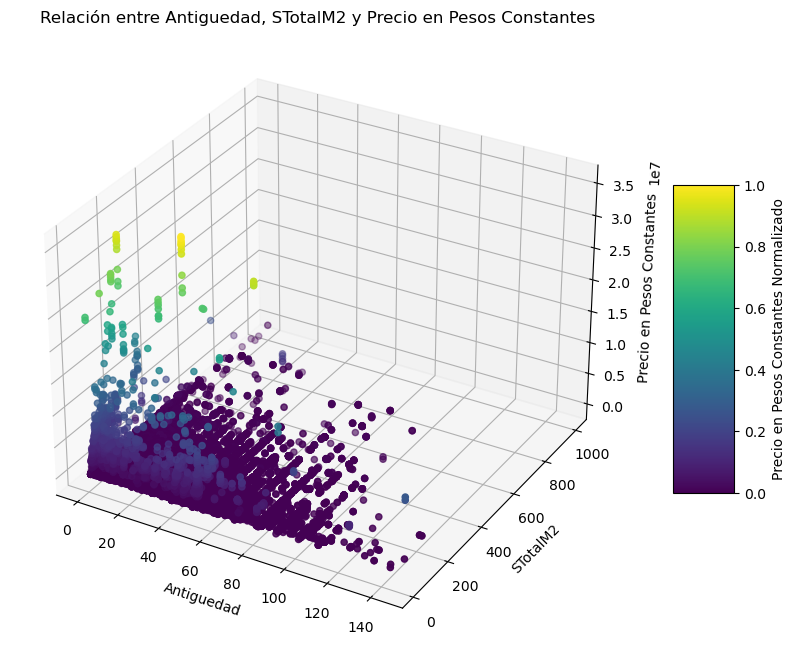

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Crear un scaler
scaler = MinMaxScaler()

# Normalizar la columna 'precio_pesos_constantes'
train_procesado['precio_pesos_constantes_normalizado'] = scaler.fit_transform(train_procesado[['precio_pesos_constantes']])
# Crear la figura y los ejes 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar los datos con colores según el precio en pesos constantes normalizado
sc = ax.scatter(train_procesado['Antiguedad'], 
                train_procesado['STotalM2'], 
                train_procesado['precio_pesos_constantes'], 
                c=train_procesado['precio_pesos_constantes_normalizado'], 
                cmap='viridis', 
                marker='o')

# Etiquetas de los ejes
ax.set_xlabel('Antiguedad')
ax.set_ylabel('STotalM2')
ax.set_zlabel('Precio en Pesos Constantes')

# Título del gráfico
ax.set_title('Relación entre Antiguedad, STotalM2 y Precio en Pesos Constantes')

# Añadir barra de color
cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Precio en Pesos Constantes Normalizado')

# Mostrar el gráfico
plt.show()

/tmp/ipykernel_9584/3547188220.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  scatter_plot.figure.colorbar(sm, label='Precio en Pesos Constantes (Log)')
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


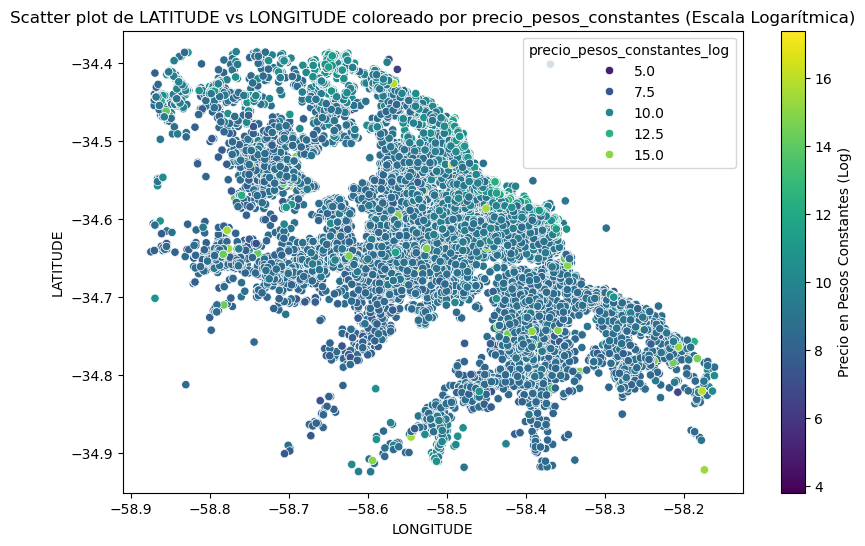

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Aplicar escala logarítmica al precio
train_procesado['precio_pesos_constantes_log'] = np.log(train_procesado['precio_pesos_constantes'])

# Crear un scatter plot de LATITUDE y LONGITUDE, coloreando por precio_pesos_constantes_log
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x=train_procesado['LONGITUDE'], 
                               y=train_procesado['LATITUDE'], 
                               hue=train_procesado['precio_pesos_constantes_log'], 
                               palette='viridis')

plt.title('Scatter plot de LATITUDE vs LONGITUDE coloreado por precio_pesos_constantes (Escala Logarítmica)')
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')

# Añadir barra de color
norm = plt.Normalize(train_procesado['precio_pesos_constantes_log'].min(), train_procesado['precio_pesos_constantes_log'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
scatter_plot.figure.colorbar(sm, label='Precio en Pesos Constantes (Log)')

plt.show()

/tmp/ipykernel_9584/1560797014.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  scatter_plot.figure.colorbar(sm, label='Antiguedad')
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


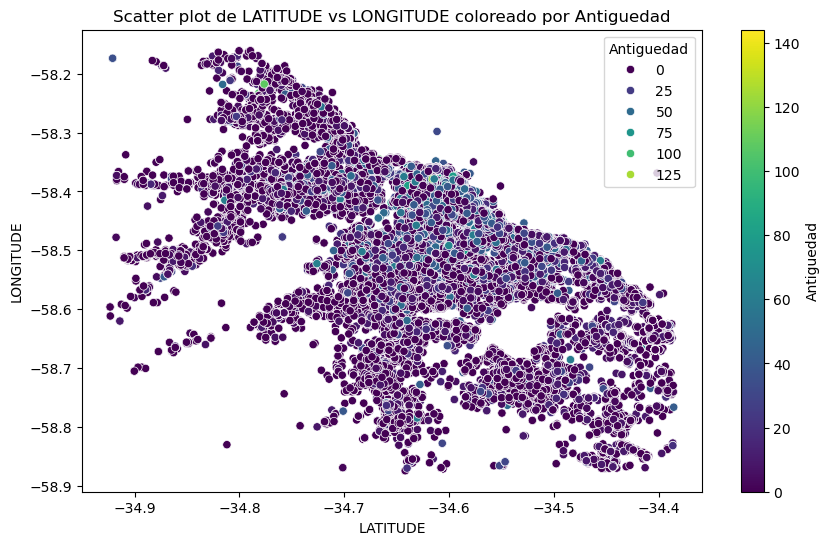

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un scatter plot de LATITUDE y LONGITUDE, coloreando por precio_pesos_constantes
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x=train_procesado['LATITUDE'], 
                               y=train_procesado['LONGITUDE'],
                               hue=train_procesado['Antiguedad'], 
                               palette='viridis')

plt.title('Scatter plot de LATITUDE vs LONGITUDE coloreado por Antiguedad')
plt.xlabel('LATITUDE')
plt.ylabel('LONGITUDE')

# Añadir barra de color
norm = plt.Normalize(train_procesado['Antiguedad'].min(), train_procesado['Antiguedad'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
scatter_plot.figure.colorbar(sm, label='Antiguedad')

plt.show()

/tmp/ipykernel_9584/223918179.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  scatter_plot1.figure.colorbar(sm1, label='Precio en Pesos Constantes')


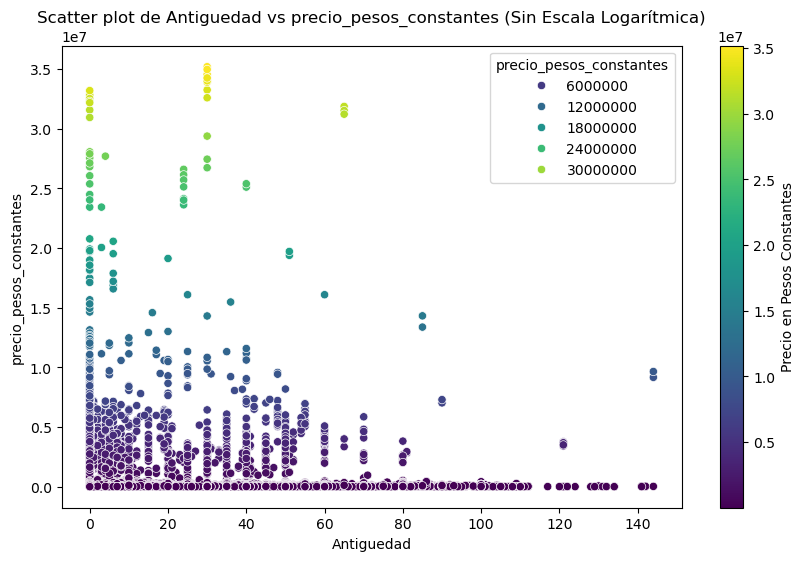

/tmp/ipykernel_9584/223918179.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  scatter_plot2.figure.colorbar(sm2, label='Precio en Pesos Constantes')


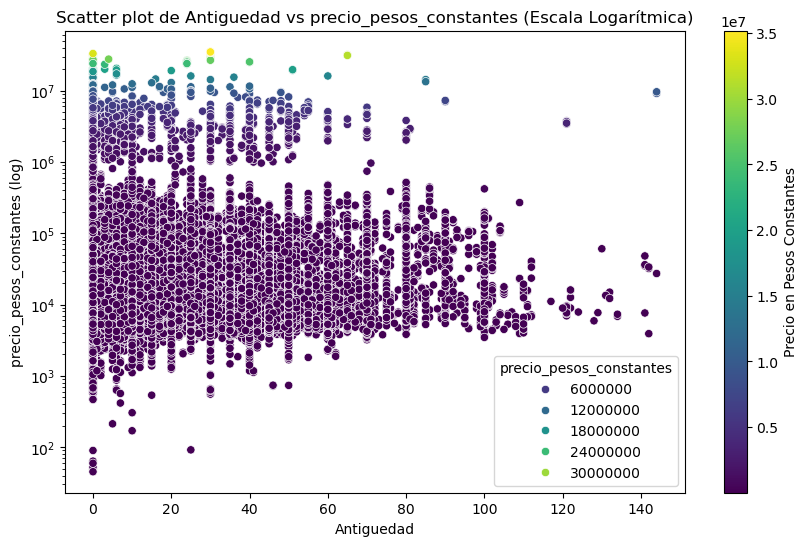

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear el primer scatter plot sin escala logarítmica
plt.figure(figsize=(10, 6))
scatter_plot1 = sns.scatterplot(x=train_procesado['Antiguedad'], 
                                y=train_procesado['precio_pesos_constantes'], 
                                hue=train_procesado['precio_pesos_constantes'], 
                                palette='viridis')

plt.title('Scatter plot de Antiguedad vs precio_pesos_constantes (Sin Escala Logarítmica)')
plt.xlabel('Antiguedad')
plt.ylabel('precio_pesos_constantes')

# Añadir barra de color
norm1 = plt.Normalize(train_procesado['precio_pesos_constantes'].min(), train_procesado['precio_pesos_constantes'].max())
sm1 = plt.cm.ScalarMappable(cmap="viridis", norm=norm1)
sm1.set_array([])
scatter_plot1.figure.colorbar(sm1, label='Precio en Pesos Constantes')

plt.show()

# Crear el segundo scatter plot con escala logarítmica
plt.figure(figsize=(10, 6))
scatter_plot2 = sns.scatterplot(x=train_procesado['Antiguedad'], 
                                y=train_procesado['precio_pesos_constantes'], 
                                hue=train_procesado['precio_pesos_constantes'], 
                                palette='viridis')

plt.title('Scatter plot de Antiguedad vs precio_pesos_constantes (Escala Logarítmica)')
plt.xlabel('Antiguedad')
plt.ylabel('precio_pesos_constantes (log)')
plt.yscale('log')

# Añadir barra de color
norm2 = plt.Normalize(train_procesado['precio_pesos_constantes'].min(), train_procesado['precio_pesos_constantes'].max())
sm2 = plt.cm.ScalarMappable(cmap="viridis", norm=norm2)
sm2.set_array([])
scatter_plot2.figure.colorbar(sm2, label='Precio en Pesos Constantes')

plt.show()

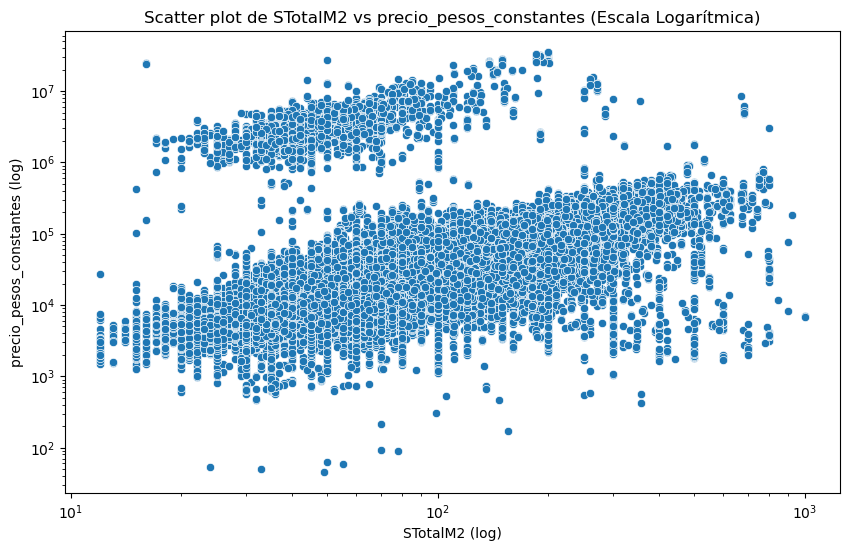

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un scatter plot de precio_pesos_constantes y STotalM2 en escala logarítmica
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x=train_procesado['STotalM2'], y=train_procesado['precio_pesos_constantes'])
scatter_plot.set(xscale="log", yscale="log")
plt.title('Scatter plot de STotalM2 vs precio_pesos_constantes (Escala Logarítmica)')
plt.xlabel('STotalM2 (log)')
plt.ylabel('precio_pesos_constantes (log)')
plt.show()

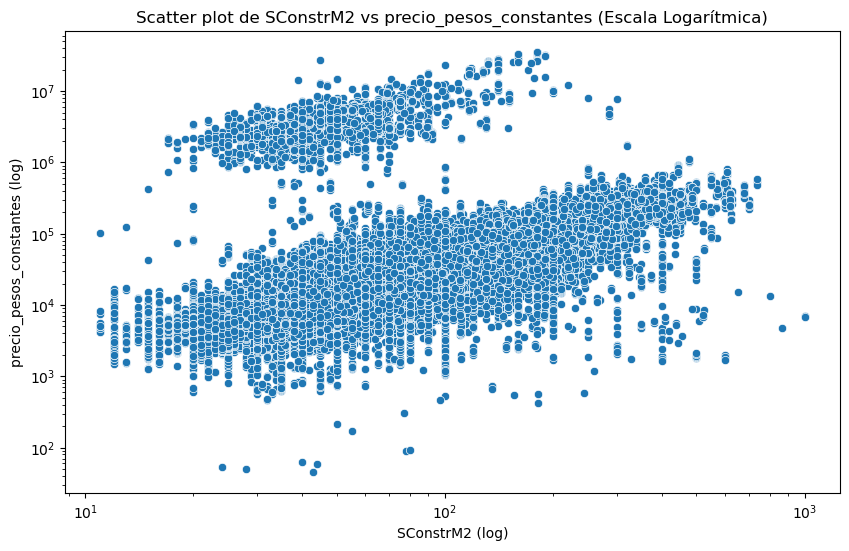

In [15]:
# Crear un scatter plot de precio_pesos_constantes y STotalM2 en escala logarítmica
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x=train_procesado['SConstrM2'], y=train_procesado['precio_pesos_constantes'])
scatter_plot.set(xscale="log", yscale="log")
plt.title('Scatter plot de SConstrM2 vs precio_pesos_constantes (Escala Logarítmica)')
plt.xlabel('SConstrM2 (log)')
plt.ylabel('precio_pesos_constantes (log)')
plt.show()

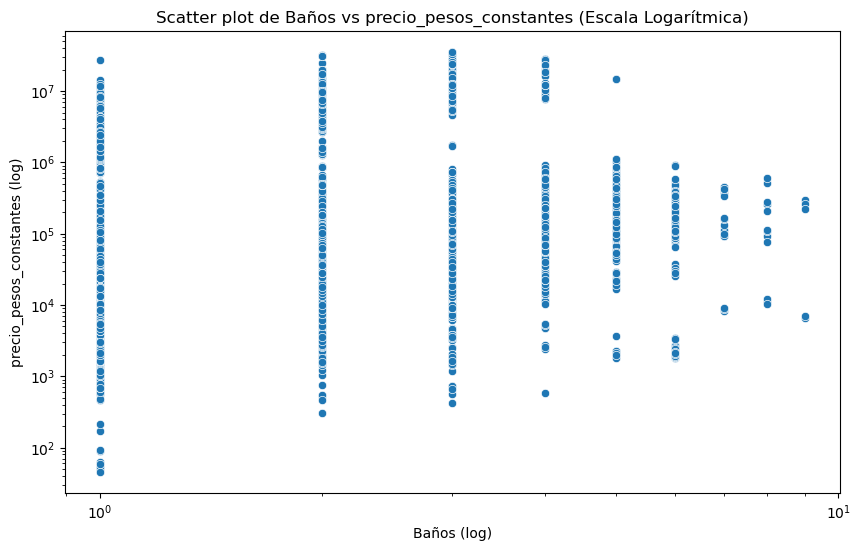

In [16]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x=train_procesado['Banos'], y=train_procesado['precio_pesos_constantes'])
scatter_plot.set(xscale="log", yscale="log")
plt.title('Scatter plot de Baños vs precio_pesos_constantes (Escala Logarítmica)')
plt.xlabel('Baños (log)')
plt.ylabel('precio_pesos_constantes (log)')
plt.show()